In [1]:
#hack till I make it a real package..
import os
import sys
sys.path.append("../../")

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4,5'
import jax 
jax.config.update('jax_disable_jit', False)


In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [3]:
#from diffhydro.utils.parallel import halo_helper


In [4]:
#halo_helper.halo_pad_1d

In [5]:
#change to your sim location!
athena_outputs_loc = "/home/ben.horowitz/DiffHydro/tests/athena_ref_outputs/kh-slip/"

ic_filename = "kh-slip.out2.00000.athdf"

ICs = athdf(athena_outputs_loc+ic_filename)


In [6]:
#manually map from athena file to my format

import jax.numpy as jnp
sol = jnp.zeros((5,128,256))

sol = sol.at[0].set(ICs["dens"][0])
sol = sol.at[1].set(ICs["mom2"][0])
sol = sol.at[2].set(ICs["mom1"][0])
sol = sol.at[3].set(ICs["mom3"][0])
sol = sol.at[-1].set(ICs["Etot"][0])

In [7]:
sol = sol[:,:,:,jnp.newaxis]

In [8]:
eq = dh.equationmanager.EquationManager()
eq.cfl=0.3
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))

In [9]:
#in practice the initialization locations are somewhat susceptable to numerical noise and/or solver method...
#for solver in loop, we start training a couple of timesteps in so we don't need to solver for that...

In [11]:
hydrosim = dh.hydro(n_super_step=1950*2,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(2,2,1))

using CTU? False


In [12]:

params = {}
q_MOL = hydrosim.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace>, 10000000000.0]


In [13]:
q_MOL[0].shape

(5, 128, 256, 1)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


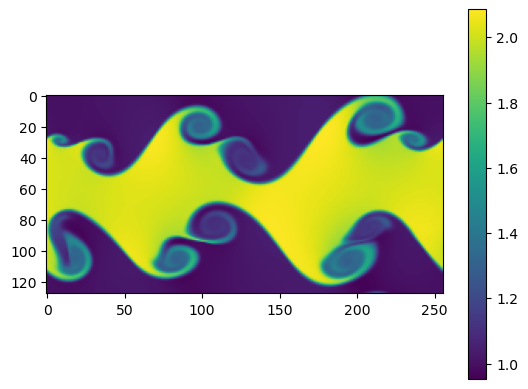

In [14]:
%pylab inline

imshow(q_MOL[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()

In [15]:
jax.debug.visualize_array_sharding(q_MOL[0][0][:,:,0])


                                                  
                                                  
          GPU 0                    GPU 1          
                                                  
                                                  
                                                  
                                                  
                                                  
          GPU 2                    GPU 3          
                                                  
                                                  
                                                  

In [16]:
from jax.sharding import NamedSharding, PartitionSpec as P

def debug_sharding(x, name="arr"):
    print(f"{name}.sharding:", x.sharding)
    # Each addressable shard should be smaller along the sharded axis
    shards = x.addressable_shards
    print(f"{name} #addressable_shards:", len(shards))
    for s in shards:
        print("  shard index:", s.index, "shape:", s.data.shape, "device:", s.device)

# Example call (inside your with self.mesh: after one pjit_step)
debug_sharding(q_MOL[0], "fields")

fields.sharding: NamedSharding(mesh=Mesh('x': 2, 'y': 2, 'z': 1), spec=PartitionSpec(None, 'x', 'y', 'z'), memory_kind=device)
fields #addressable_shards: 4
  shard index: (slice(None, None, None), slice(0, 64, None), slice(0, 128, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:0
  shard index: (slice(None, None, None), slice(0, 64, None), slice(128, 256, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:1
  shard index: (slice(None, None, None), slice(64, 128, None), slice(0, 128, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:2
  shard index: (slice(None, None, None), slice(64, 128, None), slice(128, 256, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:3


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


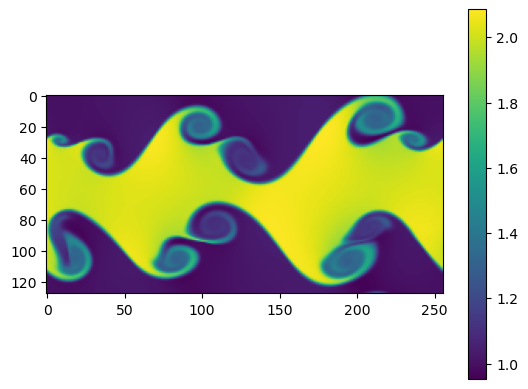

In [17]:
%pylab inline

imshow(q_MOL[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()